In [1]:
# imports
from sqlalchemy import create_engine, Column, String, Integer, Float, Date, MetaData, Table, type_coerce
from sqlalchemy.orm import mapper, create_session
import csv
from sqlalchemy import case
import numpy as np
from sqlalchemy.ext.automap import automap_base
import matplotlib.pyplot as plt
import sqlalchemy.types as types
import numbers
from sqlalchemy.sql import and_, or_, not_, func
from sqlalchemy.sql import select
import datetime as dt
import os
import re
from mpl_toolkits.basemap import Basemap
import netCDF4 as nc
%matplotlib inline

/home/eolson/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/home/eolson/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
# First, calculate river concentrations from EC data at Hope and Gravesend
# NOTE: am assuming all forms of N are reported in grams of N, so that mole conversion is 
#  by division by 14.006720 (mol. weight N), rather than weights of full molecules. This 
#  is consistent with NO23 values in Susan's notebook.
#  This is consistent with report in 'precdetectlimits.pdf', although it is rather old.
#  However, assume Si in grams of SiO2 (mo. weight = 60.08). This is consistent with 
#  Si data in Susan's notebook (http://nbviewer.jupyter.org/url/bitbucket.org/salishsea/tools/
#     raw/tip/I_ForcingFiles/Rivers/FraserRiverNutrients.ipynb?at=default&fileviewer=file-
#     view-default)
# Also appears to result in rough consistency with Debby's river Si and NO3 values
mwN=14.006720
#mwSiO3=76.083820
mwSiO2=60.08
#
#  nh4 muM  (N) = nh4_cst from mean of data at Hope/Gravesend
#  don muM  (N) = don_cst from mean of data at Hope/Gravesend
#     - only 1 data point available. Should use it or set to zero? Sutton (2013) suggests DON may be unreactive on timescales
#       of exchange of water in SoG, but Clair (2013) reports that organic nitrogen dominated total nitrogen in 
#       Canadian rivers.
#       -> for now, using available data point
#  no3 muM  (N) -> daily from smoothed data
#  sil muM (Si) -> daily from smoothed data
#  dia muM  (N) = 0.001
dia = 0.001
#  phy muM  (N) = 0.001
phy = 0.001
#  mes muM  (N) = 0.001
mes = 0.001
#  zoo muM  (N) = 0.001
zoo = 0.001
#  pon muM  (N) = 0.0
pon = 0.0
#  bsi muM (Si) = 0.0
don=0.0
bsi = 0.0
#  oxy ? empty
oxy = 160
# other rivers const vals:
const_si=55.69
const_no=6.26
const_nh=4.09
const_tur=1.0 # default river turbidity (NTU)

In [3]:
# load EC Rivers database
dbpath='/ocean/eolson/MEOPAR/obs/ECRivers/ECRiversDB'
engine = create_engine('sqlite:///'+dbpath+'.sqlite')
Base = automap_base()
Base.prepare(engine, reflect=True)
Profs=Base.classes.profiles
session = create_session(bind = engine, autocommit = False, autoflush = True)
# relevant data types: 
#('NITROGEN DISSOLVED NITRATE',)
#('NITROGEN DISSOLVED NO3 & NO2',)
#('NITROGEN DISSOLVED ORGANIC (CALCD.)',)
#('NITROGEN NITRITE',)
#('NITROGEN TOTAL',)
#('NITROGEN TOTAL DISSOLVED',)
#('NITROGEN TOTAL ORGANIC (CALCD.)',)
#('SALINITY',)
#('SILICA DISSOLVED',)
#('SILICA EXTRACTABLE',)
#('SILICA REACTIVE',)
#('SILICON DISSOLVED',)
#('SILICON EXTRACTABLE',)
#('SILICON TOTAL',)
#('TURBIDITY',)


In [4]:
#define function to plot results of query as repeating fxn of year-day if output rows contain Year, Month, Day, value:
def plotYMDV(qout,pcolor,ptitle):
    Y=[]
    M=[]
    D=[]
    Amm=[]
    date=[]
    for Y0, M0, D0, Amm0 in qout:
        Y.append(Y0)
        M.append(M0)
        D.append(D0)
        Amm.append(Amm0)
        date.append(dt.date(Y0,M0,D0))
    Y=np.array(Y)
    M=np.array(M)
    D=np.array(D)
    Amm=np.array(Amm)
    date=np.array(date)
    YD=0.0*Y
    for i in range(0,len(Y)):
        YD[i]=date[i].timetuple().tm_yday
    plt.plot(YD,Amm,'.',color=pcolor)
    plt.plot(YD+365.0,Amm,'.',color=pcolor)
    plt.title(ptitle)
    plt.plot((366,366),(0,np.max(Amm)),'k--')
    return(YD,Amm)
    
# definte function to smooth data with gaussian filter, plot result, and return dict of days, values
def gsmooth(YD,Amm,L):
    allt=np.arange(1,367)
    fil=np.empty(np.size(allt))
    s=L/2.355
    sdict={}
    for t in allt:
        diff=[min(abs(x-t),abs(x-t+365), abs(x-t-365)) for x in YD]
        weight=[np.exp(-.5*x**2/s**2) if x <= 3*L else 0.0 for x in diff]
        #weight=[np.exp(-.5*x**2/s**2) for x in diff]
        fil[t-1]=np.sum(weight*Amm)/np.sum(weight)
        sdict[t]=fil[t-1]
    plt.plot(allt,fil,'k-')
    plt.plot(allt+365,fil,'k-')
    diff_ex=[min(abs(x-t),abs(x-t+365), abs(x-t-365)) for x in allt]
    weight_ex=[np.exp(-.5*x**2/s**2) if x <= 3*L else 0.0 for x in diff_ex]
    plt.plot(allt,weight_ex/np.sum(weight_ex)*np.max(2.0*Amm),'k:')
    plt.plot(allt+365,weight_ex/np.sum(weight_ex)*np.max(2.0*Amm),'k:')
    return(sdict)
    #plt.plot(YD,weight,'*')

units: ('MG/L',)
don_cst = 17.1346325192 uM N ....DON"T USE


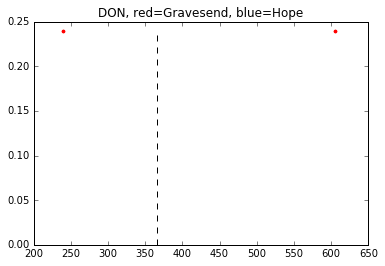

In [5]:
# calculate mean DON from data at Hope and Gravesend:

qdataG=session.query(Profs.Year, Profs.Month, Profs.Day, Profs.value).\
            filter(and_(
                Profs.variable_name=='NITROGEN DISSOLVED ORGANIC (CALCD.)',
                Profs.station_name=='Fraser River (Main Arm) at Gravesend Reach - Buoy'))
if qdataG.count()>0:
    YDG, valG = plotYMDV(qdataG.all(),'r','DON, red=Gravesend, blue=Hope')
    
qdataH=session.query(Profs.Year, Profs.Month, Profs.Day, Profs.value).\
            filter(and_(
                Profs.variable_name=='NITROGEN DISSOLVED ORGANIC (CALCD.)',
                Profs.station_name.like('%Hope%')))
if qdataH.count()>0:
    YDH, valH = plotYMDV(qdataH.all(),'b',)
else:
    YDH=[]
    valH=[]

units=session.query(Profs.unit_code).\
            filter(and_(
                Profs.variable_name=='NITROGEN DISSOLVED ORGANIC (CALCD.)',
                or_(Profs.station_name=='Fraser River (Main Arm) at Gravesend Reach - Buoy',
                    Profs.station_name.like('%Hope%')))).group_by(Profs.unit_code).all()
for row in units:
    print('units:',row)
val=np.concatenate((valG,valH))
don_cst=np.mean(val)
print('don_cst =', don_cst/mwN*1000, 'uM N ....DON"T USE')

units: ('MG/L',)
nh4_cst = 4.42713321781 uM


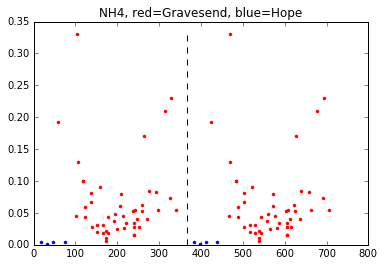

In [6]:
# calculate mean NH4 from data at Hope and Gravesend

dataG=session.query(Profs.Year, Profs.Month, Profs.Day, Profs.value).\
            filter(and_(
                Profs.variable_name=='AMMONIA DISSOLVED',
                Profs.station_name=='Fraser River (Main Arm) at Gravesend Reach - Buoy')).all()
YDG, valG = plotYMDV(dataG,'r','temp')
    
dataH=session.query(Profs.Year, Profs.Month, Profs.Day, Profs.value).\
            filter(and_(
                Profs.variable_name=='AMMONIA DISSOLVED',
                Profs.station_name.like('%Hope%'))).all()
YDH, valH = plotYMDV(dataH,'b','NH4, red=Gravesend, blue=Hope')

units=session.query(Profs.unit_code).\
            filter(and_(
                Profs.variable_name=='AMMONIA DISSOLVED',
                or_(Profs.station_name=='Fraser River (Main Arm) at Gravesend Reach - Buoy',
                    Profs.station_name.like('%Hope%')))).group_by(Profs.unit_code).all()
for row in units:
    print('units:',row)
val=np.concatenate((valG,valH))
nh4_cst=np.mean(val)
print('nh4_cst =', nh4_cst/mwN*1000, 'uM')

units: ('MG/L',)


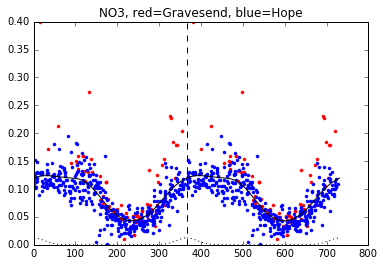

In [7]:
# NO2+NO3 at Hope and Gravesend
dataG=session.query(Profs.Year, Profs.Month, Profs.Day, Profs.value).\
            filter(and_(
                Profs.value<2.5, # remove single high outlier
                Profs.variable_name=='NITROGEN DISSOLVED NO3 & NO2',
                Profs.station_name.like('%Gravesend%'))).all()
YDG, valG = plotYMDV(dataG,'r','temp')

dataH=session.query(Profs.Year, Profs.Month, Profs.Day, Profs.value).\
            filter(and_(
                Profs.variable_name=='NITROGEN DISSOLVED NO3 & NO2',
                Profs.station_name.like('%Hope%'))).all()
YDH, valH = plotYMDV(dataH,'b','NO3, red=Gravesend, blue=Hope')

units=session.query(Profs.unit_code).\
            filter(and_(
                Profs.variable_name=='NITROGEN DISSOLVED NO3 & NO2',
                or_(Profs.station_name.like('%Gravesend%'),
                    Profs.station_name.like('%Hope%')))).group_by(Profs.unit_code).all()
for row in units:
    print('units:',row)
    
YD=np.concatenate((YDG,YDH))
val=np.concatenate((valG, valH))
no3dict=gsmooth(YD,val,60)
#print(i,np.max([v for v in no3dict.values()]))

units: ('MG/L',)


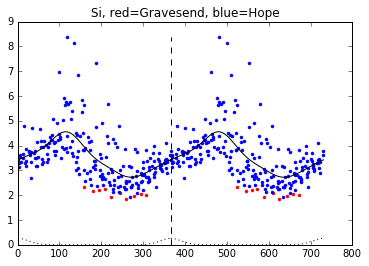

In [8]:
# Si at Hope and Gravesend
dataG=session.query(Profs.Year, Profs.Month, Profs.Day, Profs.value).\
            filter(and_(
                Profs.value<2.5, # remove single high outlier
                or_(Profs.variable_name=='SILICA DISSOLVED',
                      Profs.variable_name=='SILICON DISSOLVED'),
                Profs.station_name.like('%Gravesend%'))).all()
YDG, valG = plotYMDV(dataG,'r','temp')

dataH=session.query(Profs.Year, Profs.Month, Profs.Day, Profs.value).\
            filter(and_(
                or_(Profs.variable_name=='SILICA DISSOLVED',
                      Profs.variable_name=='SILICON DISSOLVED'),
                Profs.station_name.like('%Hope%'))).all()
YDH, valH = plotYMDV(dataH,'b','Si, red=Gravesend, blue=Hope')

units=session.query(Profs.unit_code).\
            filter(and_(
                or_(Profs.variable_name=='SILICA DISSOLVED',
                      Profs.variable_name=='SILICON DISSOLVED'),
                or_(Profs.station_name.like('%Gravesend%'),
                    Profs.station_name.like('%Hope%')))).group_by(Profs.unit_code).all()
for row in units:
    print('units:',row)
    
YD=np.concatenate((YDG,YDH))
val=np.concatenate((valG, valH))
sidict=gsmooth(YD,val,60)

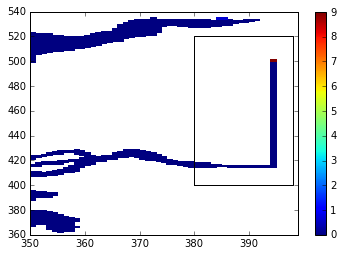

In [9]:
# find fraser location
mesh=nc.Dataset('/ocean/eolson/MEOPAR/NEMO-forcing/grid/mesh_mask201702.nc')
tmask=mesh.variables['tmask'][0,0,:,:]
f=nc.Dataset('/results/forcing/rivers/R201702DFraCElse_y2016m01d23.nc') # example for dims
plt.pcolormesh(np.ma.masked_where(tmask==0,f.variables['rorunoff'][0,:,:]))
plt.colorbar()
plt.xlim(350,399)
plt.ylim(360,540)
plt.plot((380,398,398,380,380),(400,400,520,520,400),'k-')

In [10]:
f.variables['time_counter'][:]

masked_array(data = [--],
             mask = [ True],
       fill_value = 9.96921e+36)

In [11]:
# create daily files, use data to initialize fields
year=2016
fname='/data/eolson/MEOPAR/NEMO-forcing-new/rivers-climatology/bio/R201809_2_bioClim_'
for yearday in range(1,367):
    t2=dt.date(year, 1, 1) + dt.timedelta(days = yearday - 1)
    #datestr='y'+t2.strftime('%Y')+'m'+t2.strftime('%m')+'d'+t2.strftime('%d')
    datestr='m'+t2.strftime('%m')+'d'+t2.strftime('%d')
    new=nc.Dataset(fname+datestr+'.nc','w')
    #Copy dimensions
    for dname, the_dim in f.dimensions.items():
        #print (dname, len(the_dim) if not the_dim.isunlimited() else None)
        new.createDimension(dname, len(the_dim) if not the_dim.isunlimited() else None)
    #new_tc=new.createVariable('time_counter',float,('time_counter'),zlib=True)
    #new_tc[:]=f.variables['time_counter'][:]
    
    new_run=new.createVariable('no3',float,('time_counter', 'y', 'x'),zlib=True)
    new_run[:,:,:]=const_no # other river value
    new_run[:,400:520,380:]=no3dict[yearday]/mwN*1000.0 # convert to muM; Fraser value

    new_run=new.createVariable('sil',float,('time_counter', 'y', 'x'),zlib=True)
    new_run[:,:,:]=const_si # other river value
    new_run[:,400:520,380:]=sidict[yearday]/mwSiO2*1000.0 # convert to muM; Fraser value
    
    new.close()

In [12]:
# create constants file
f=nc.Dataset('/results/forcing/rivers/R201702DFraCElse_y2016m01d23.nc') # example for dims
year=2016
fnameC='/data/eolson/MEOPAR/NEMO-forcing-new/rivers-climatology/bio/R201809_2_bioConst'
new=nc.Dataset(fnameC+'.nc','w')
#Copy dimensions
for dname, the_dim in f.dimensions.items():
    #print (dname, len(the_dim) if not the_dim.isunlimited() else None)
    new.createDimension(dname, len(the_dim) if not the_dim.isunlimited() else None)

#new_tc=new.createVariable('time_counter',float,('time_counter'),zlib=True)
#new_tc[:]=f.variables['time_counter'][:]

new_run=new.createVariable('no3',float,('time_counter', 'y', 'x'),zlib=True)
new_run[:,:,:]=const_no # other rivers
new_run[:,400:520,380:]=np.mean([no3dict[yearday]/mwN*1000.0 for yearday in range(1,367)])

new_run=new.createVariable('nh4',float,('time_counter', 'y', 'x'),zlib=True)
new_run[:,:,:]=const_nh # other river value
new_run[:,400:520,380:]=nh4_cst/mwN*1000.0 # convert to muM; Fraser value

new_run=new.createVariable('sil',float,('time_counter', 'y', 'x'),zlib=True)
new_run[:]=const_si # other river value
new_run[:,400:520,380:]=np.mean([sidict[yearday]/mwSiO2*1000.0 for yearday in range(1,367)])

new_run=new.createVariable('dia',float,('time_counter', 'y', 'x'),zlib=True)
new_run[:]=dia

new_run=new.createVariable('phy',float,('time_counter', 'y', 'x'),zlib=True)
new_run[:]=phy

new_run=new.createVariable('mes',float,('time_counter', 'y', 'x'),zlib=True)
new_run[:]=mes

new_run=new.createVariable('zoo',float,('time_counter', 'y', 'x'),zlib=True)
new_run[:]=zoo

new_run=new.createVariable('don',float,('time_counter', 'y', 'x'),zlib=True)
new_run[:]=don

new_run=new.createVariable('pon',float,('time_counter', 'y', 'x'),zlib=True)
new_run[:]=pon

new_run=new.createVariable('bsi',float,('time_counter', 'y', 'x'),zlib=True)
new_run[:]=bsi

new_run=new.createVariable('tur',float,('time_counter', 'y', 'x'),zlib=True)
new_run[:]=const_tur

new.close()

In [13]:
session.close()
engine.dispose()

In [14]:
f.close()
mesh.close()

In [15]:
year=2016
for yearday in range(1,367):
    t2=dt.date(year, 1, 1) + dt.timedelta(days = yearday - 1)
    #datestr='y'+t2.strftime('%Y')+'m'+t2.strftime('%m')+'d'+t2.strftime('%d')
    datestr='m'+t2.strftime('%m')+'d'+t2.strftime('%d')
    new=nc.Dataset(fname+datestr+'.nc')
    print(yearday,[(ikey, np.min(new.variables[ikey]), np.max(new.variables[ikey])) for ikey in new.variables.keys()])
    new.close()

1 [('no3', 6.2599999999999998, 8.5279323029169447), ('sil', 55.689999999999998, 57.026294520587676)]
2 [('no3', 6.2599999999999998, 8.551341389403051), ('sil', 55.689999999999998, 57.155069119773565)]
3 [('no3', 6.2599999999999998, 8.5738681112032893), ('sil', 55.689999999999998, 57.283052274097649)]
4 [('no3', 6.2599999999999998, 8.5955059958683311), ('sil', 55.689999999999998, 57.410246425638078)]
5 [('no3', 6.2599999999999998, 8.6162492485283089), ('sil', 55.689999999999998, 57.536655230887035)]
6 [('no3', 6.2599999999999998, 8.6360929182465096), ('sil', 55.689999999999998, 57.662283869098438)]
7 [('no3', 6.2599999999999998, 8.6550330552453154), ('sil', 55.689999999999998, 57.787139371023834)]
8 [('no3', 6.2599999999999998, 8.6730668564505784), ('sil', 55.689999999999998, 57.911230964311336)]
9 [('no3', 6.2599999999999998, 8.6901927970457979), ('sil', 55.689999999999998, 58.034570432146282)]
10 [('no3', 6.2599999999999998, 8.7064107461614508), ('sil', 55.689999999999998, 58.15717248

In [16]:
new=nc.Dataset(fnameC+'.nc')
print(yearday,[(ikey, np.min(new.variables[ikey]), np.max(new.variables[ikey])) for ikey in new.variables.keys()])
new.close()

366 [('no3', 6.2599999999999998, 6.4369529952319278), ('nh4', 4.0899999999999999, 4.4271332178136902), ('sil', 55.689999999999998, 58.655887856134882), ('dia', 0.001, 0.001), ('phy', 0.001, 0.001), ('mes', 0.001, 0.001), ('zoo', 0.001, 0.001), ('don', 0.0, 0.0), ('pon', 0.0, 0.0), ('bsi', 0.0, 0.0), ('tur', 1.0, 1.0)]
